In [2]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from graph_sim_v2 import*
from itertools import combinations

In [25]:
class DAGSampler:
    def __init__(self, library=[], num_nodes=3, admg=False):
        if library == None:
            self.library = []
        else:
            self.library = library
            
        self.num_nodes = num_nodes
        self.admg = admg  # whether to also sample bidirected edges
        # calculate the number of elements in a lower triangular matrix num_nodes x num_nodes
        # this is also the number of possible pairs
        self.num_pairs = num_nodes * (num_nodes - 1) / 2
           
    
    def _dag_gen(self, num_nodes):
        '''
        :param num_nodes: number of desired nodes in sampled DAG (int)
        :return: canonical form: unique graph for isomorphic set [num_nodes x num_nodes]
        '''
        # randomly generate edges for graph
        ran_lotril = np.random.randint(0, high=2, size=int(self.num_pairs))

        # populate the lower triangular matrix with the randomly generated edges
        idx = np.tril_indices(num_nodes, k=-1)
        matrix = np.zeros((num_nodes, num_nodes)).astype(int)
        matrix[idx] = ran_lotril
        return nx.from_numpy_matrix(matrix, create_using=nx.MultiDiGraph)    
    
    def _generate_canonical_library(self, num_nodes, graph_history, verbose=False):
        # generate a networkx object digraph (DAG)
        dag_nx = self._dag_gen(num_nodes=num_nodes)
        
        if self.admg:
            dag_nx = self._add_unobserved(dag_nx)

        ug_nx = self._dag_to_ug(dag_nx)  # transform sampled DAG into UG

        already_sampled = False
        for d_nx in graph_history:
            ug_d_nx = self._dag_to_ug((d_nx))  # transform history into UG
            already_sampled = nx.is_isomorphic(ug_d_nx, ug_nx)  # check if isomorphic with any in history

            if already_sampled == False:
                pass
            else:
                break
                
        if not already_sampled:  # if we haven't already sampled this canonical form, return it
            if verbose == True:
                print('New graph found.') 
            return dag_nx, already_sampled
        else:
            if verbose == True: 
                print('Graph already sampled.') 
            return None, already_sampled
        
        
    def _dag_to_ug(self, dag):
        num_nodes = dag.number_of_nodes()
        UG = nx.Graph()
        a = num_nodes
        for edge in dag.edges:
            from_ = edge[0]
            to_ = edge[1]
            UG.add_edge(from_, a)
            UG.add_edge(a, to_)
            UG.add_edge(from_, a + 1)
            UG.add_edge(a + 1, a)
            a += 2
        return UG    
    
    def _edge_probas(self, graph):
        # gets edge probabilities
        num_edges = len(graph.edges)
        probas = np.random.uniform(0.5, 1, size=num_edges)
        return probas

        
    def _add_unobserved(self, graph):
        # pick number of unobserved
        num_unobs = np.random.randint(1, self.num_nodes) # at least one unobserved var for admg
        # list all nodes
        nodes = np.arange(self.num_nodes)
        # enumerate all possible pairs
        pairs = [comb for comb in combinations(nodes, 2)]
        # pick num_obs from list of possible pairs
        unobs_links = [pairs[i] for i in range(num_unobs)]

        for i, nodes in enumerate(unobs_links):
            from_ = nodes[0]
            to_ = nodes[1]
            u_name = 'U{}'.format(i)
            graph.add_node(u_name)
            graph.add_edge(u_name, from_, weight=1)
            graph.add_edge(u_name, to_, weight=1)

        return graph 
        
    def generate_library(self, plot=False, verbose=False, max_iters=100, epsilon=0.1):
        t = trange(max_iters, desc='Rate:', leave=True)
        new_graphs = 0 
        
        for i in t:
        
            graph, already_sampled_flag = self._generate_canonical_library(num_nodes=self.num_nodes,
                                                                     graph_history=self.library,
                                                                         verbose=verbose)
                
            if (graph != None) and (plot == True):
                self.show_graph(graph, directed=True)               
                
            if already_sampled_flag:
                pass
            else:
                new_graphs += 1
                self.library.append(graph)
                
            q =  new_graphs/(i+1)# new graph discovery rate
            t.set_description("Rate: {})".format(np.round(q, 4)))
            t.refresh() # to show immediately the update
            
            if q <= epsilon:
                print('Graph discovery rate fallen below epsilon = {}'.format(epsilon))
                break
        return self.library
                
    def edge_weighting(self, graph):
              
        edge_weights = self._edge_probas(graph)
        
        for i, e in enumerate(graph.edges(data=True)):
            from_ = e[0]
            to_ = e[1]
            graph[from_][to_][0]['weight'] = edge_weights[i]
            
        if self.admg:
            U_nodes = [node for node in graph.nodes() if 'U' in str(node)]
            for node in U_nodes:
                edge = list(graph.edges(node, data=True))
                from_ = edge[0][1]
                to_ = edge[1][1]
                edge_w1 = edge[0][2]['weight']
                edge_w2 = edge[1][2]['weight']
                av_weight = (edge_w1 + edge_w2) / 2
                graph[node][from_][0]['weight'] = av_weight
                graph[node][to_][0]['weight'] = av_weight
        
        return graph
    

    def show_graph(self, graph, directed, weights=False):
        # function for plotting a graph (directed or undirected)
        labels = nx.get_edge_attributes(graph, 'weight')
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, node_size=500, with_labels=True, arrows=directed, connectionstyle='arc3, rad = 0.1')
        if weights:
            labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in graph.edges(data=True)])
            nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
        plt.show()

Rate: 0.1):  70%|██████▉   | 139/200 [00:00<00:00, 615.97it/s]   


Graph discovery rate fallen below epsilon = 0.1


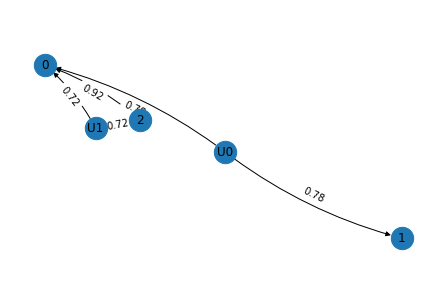

In [26]:

# Example Usage:
# epsilon is the minimum graph discovery rate 
ds = DAGSampler(library=[], num_nodes=3, admg=True)
ds.generate_library(plot=False, verbose=False, max_iters=200, epsilon=0.1)

graph = ds.library[0]
proba_graph = ds.edge_weighting(graph=graph)
ds.show_graph(proba_graph, directed=True, weights=True)

In [27]:
ds = DAGSampler(library=None, num_nodes=3, admg=True)

In [28]:
lib = ds.generate_library(plot=False, verbose=False, max_iters=200, epsilon=0.1)

Rate: 0.1):  70%|██████▉   | 139/200 [00:00<00:00, 676.82it/s]   

Graph discovery rate fallen below epsilon = 0.1


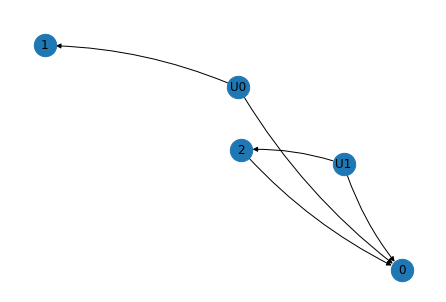

In [21]:
graph = ds.library[0]
ds.show_graph(graph, directed=True)

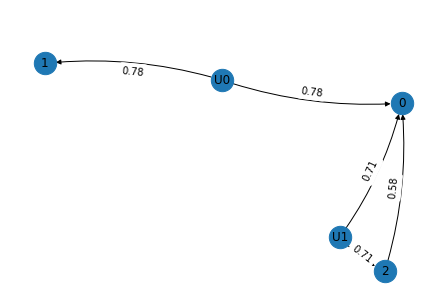

In [22]:
graph_proba = ds.edge_weighting(graph)
ds.show_graph(graph_proba, directed=True, weights=True)